In [1]:
import cartopy.crs as ccrs
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import scipy.spatial
import trimesh
import xarray as xr
from numpyro.infer import MCMC, NUTS

from DDV import eigenbasis, sph_utils

radius = 1

In [2]:
data = xr.open_dataset('../data/world_hourly_wind_850.nc')
data = data.where(np.abs(data['latitude']) < 90, drop=True)

In [3]:
lons = data.variables['longitude'][:].data
lats = data.variables['latitude'][:].data

lats = lats[np.abs(lats) < 90]

lons_grid, lats_grid = np.meshgrid(lons, lats)

Project 10 degree latitude/longitude grid to a sphere and generate a mesh

In [4]:
points = sph_utils.conv_lat_lon(lats_grid.flatten(), lons_grid.flatten(), r=radius)

points_aug_n = np.array([[0, 0, radius]])
points_aug_s = np.array([[0, 0, -radius]])

all_points = np.concatenate((points, points_aug_n, points_aug_s))

convex_hull = scipy.spatial.ConvexHull(all_points)
mesh = trimesh.Trimesh(convex_hull.points, convex_hull.simplices)


Generate a basis for curling and diverging fields with respect to the mesh.

In [5]:
sphere_eigen_val, sphere_eigen_vec_d, sphere_eigen_vec_c, vol, sph_c = eigenbasis.generate_vector_basis(
    mesh.vertices, mesh.faces, depth=250)

C:\Users\mg874\anaconda3\Lib\site-packages\pydec\dec\simplicial_complex.py:177: RuntimeWarning: divide by zero encountered in divide
  data.star_inv = sparse.spdiags([1.0/stardiag],[0], N, N, format='csr')
Processing eigenvectors:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Project all observed u- and v- vector fields to the vertices of the mesh.

In [6]:
def project_to_xyz(points, tangents_u, tangents_v):
    basis_northing, basis_easting = sph_utils.spherical_tangent_basis(points, r=radius)

    projected_vecs = np.zeros((tangents_u.shape[0], tangents_u.shape[1], 3))

    for i in range(tangents_u.shape[0]):
        projected_vecs[i] = tangents_u[i][:, None] * basis_easting + tangents_v[i][:, None] * basis_northing

    return projected_vecs


u = data["u"].values[:, 0, :, :]
v = data["v"].values[:, 0, :, :]

u_zonal = np.mean(u, axis=(0, 2))
v_zonal = np.mean(v, axis=(0, 2))

u_corrected = u - u_zonal[np.newaxis, :, np.newaxis]
v_corrected = v - v_zonal[np.newaxis, :, np.newaxis]

u_np = u_corrected.reshape(u.shape[0], -1)
v_np = v_corrected.reshape(v.shape[0], -1)

obs_vecs = project_to_xyz(points, u_np, v_np)
obs_vecs = obs_vecs.reshape(obs_vecs.shape[0], -1)

obs_var = np.mean(np.sum(obs_vecs ** 2, axis=1))

# obs_vecs /= obs_vecs_mean_norm
obs_vecs /= np.sqrt(obs_var)


Parameters for inference ($\kappa$ will be inferred as a function of latitude

In [7]:
params = {
    "s_c": 1,
    "v": 0.5
}

Alternative versions of functions found in [kernel.py](../kernel.py) to omit the diverging basis for improved performance.

In [10]:
def matern_scaling_ns(l, k, v, dim):
    if v == jnp.inf:
        return jnp.exp(-((k ** 2) / 2.) * l)
    else:
        return jnp.power(((2 * v) / (k[:, None].T ** 2)) + l[:, None], - v - (dim / 2.))


def vector_mesh_kernel_ns(eigenvalues, c_eigenfields, points_1, points_2, dim, vol, kappa_c, params):
    eigenvalues = jnp.array(eigenvalues)

    c_eigenfields = jnp.array(c_eigenfields)

    kappa_c = jnp.array(kappa_c)

    points_1 = jnp.array(points_1)
    points_2 = jnp.array(points_2)

    ms_c = matern_scaling_ns(eigenvalues, kappa_c, params["v"], dim)

    ms_c = ms_c / jnp.sqrt(eigenvalues[:, jnp.newaxis])

    c_fields_1 = jnp.multiply(c_eigenfields[points_1], jnp.expand_dims(jnp.sqrt(ms_c.T[points_1]), 1))
    c_fields_2 = jnp.multiply(c_eigenfields[points_2], jnp.expand_dims(jnp.sqrt(ms_c.T[points_2]), 1))

    K_c = jnp.einsum('ijm,klm->ikjl', c_fields_1, c_fields_2)

    K_c = K_c.transpose((0, 2, 1, 3)).reshape((len(points_1) * dim, len(points_2) * dim))

    # Compute scaling coefficients
    c_c = jnp.sum(jnp.mean(ms_c, axis=1)) / vol

    # Final kernel with variance scaling
    K = ((params["s_c"] ** 2) / c_c) * K_c

    return K

Create an MCMC model using numpyro to infer radial basis function weights to model $\kappa$ as a function of latitude.

In [11]:
n_points = len(points)


def latitude_rbf_basis(latitudes, centers, epsilon=20.0):
    """Compute RBF basis functions over latitude."""
    return jnp.exp(-((latitudes[:, None] - centers[None, :]) ** 2) / (2 * epsilon ** 2))


M = 20
centers = jnp.linspace(-90, 90, M)
phi_basis = latitude_rbf_basis(lats_grid.flatten(), centers)


def nonstationary_model(Y):
    weights = numpyro.sample("weights", dist.Normal(0.0, 1.0).expand([M]))

    kappa = jax.nn.softplus(jnp.dot(phi_basis, weights)) + 1

    kernel = vector_mesh_kernel_ns(jnp.array(sphere_eigen_val[1:]), sphere_eigen_vec_c[:-2, :, 1:], range(n_points),
                                   range(n_points), 3, vol, kappa, params) + 1e-1 * jnp.eye(n_points * 3)

    with numpyro.plate("realizations", Y.shape[0]):
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(
                loc=np.zeros(n_points * 3),
                covariance_matrix=kernel,
                validate_args=True
            ),
            obs=Y
        )

Sanity check to ensure model is correct by running a single iteration and ensuring shapes are sensible

In [13]:
from numpyro.handlers import seed, trace

tr = trace(seed(nonstationary_model, jax.random.PRNGKey(0))).get_trace(Y=obs_vecs)
for name, site in tr.items():
    print(f"{name}: {site['value'].shape}")


weights: (20,)
realizations: (2208,)
obs: (2208, 1836)


Run MCMC:

In [32]:
nuts_kernel = NUTS(nonstationary_model,
                   max_tree_depth=6,
                   adapt_step_size=True,
                   adapt_mass_matrix=True)

# Run MCMC
mcmc = MCMC(nuts_kernel,
            num_warmup=100,
            num_samples=500)

mcmc.run(jax.random.PRNGKey(0), Y=obs_vecs)

summary_dict = numpyro.diagnostics.summary(mcmc.get_samples(), group_by_chain=False)

for k, v in summary_dict.items():
    spaces = " " * max(12 - len(k), 0)
    print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))

sample: 100%|██████████| 600/600 [1:05:06<00:00,  6.51s/it, 7 steps of size 4.62e-01. acc. prob=0.85] 

[weights_c]     	 max r_hat: 1.0099


Plot $\kappa$ as a function of latitude by combining the posterior means of the Gaussian weights with the basis functions.

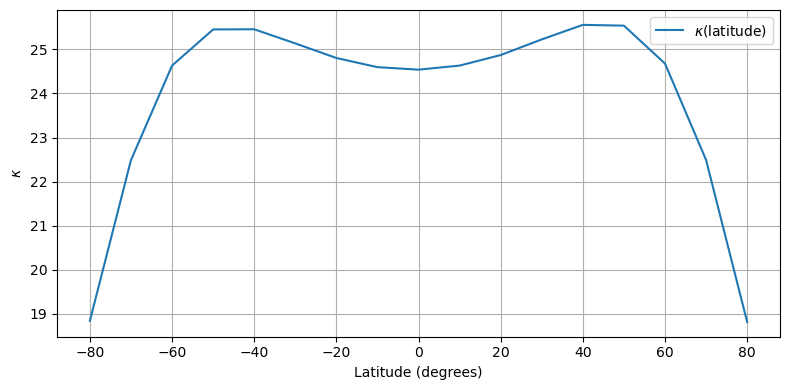

In [39]:
weights_c_post_mean = summary_dict["weights_c"]['mean']

kappa_lat = jax.nn.softplus(jnp.dot(phi_basis, weights_c_post_mean)) + 1

plt.figure(figsize=(8, 4))
plt.plot(lats_grid.flatten(), kappa_lat, label=f"$\kappa$(latitude)")
plt.xlabel("Latitude (degrees)")
plt.ylabel(f"$\kappa$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('plots/kappa-lat.png', bbox_inches='tight', dpi=400)